In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.api as sm
import time
from tqdm import tqdm
from statsmodels.nonparametric.kernel_regression import KernelReg
import geopandas as gpd
import pandas as pd
import plotly.express as px

In [2]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('Clean_Data_17-04.csv')
# data

In [3]:
# Load shapefile for Greater Copenhagen municipalities
municipalities_shapefile = "C:/Users/jtami/Downloads/denmark_Municipality_level_2/denmark_Municipality_level_2.shp"
municipalities_gdf = gpd.read_file(municipalities_shapefile)
municipalities_gdf.rename(columns={'shape2': 'Kommune'}, inplace=True)
municipalities_gdf.loc[3, 'Kommune'] = 'København'

In [4]:
municipalities_gdf

,Kommune,shapeiso,shapeid,shapegroup,shapetype,shape1,shape0,geometry
0,Assens,None,71786716B65540528804322,DNK,ADM2,Syddanmark,denmark,"MULTIPOLYGON (((10.01936 55.12016, 9.98880 55...."
1,Guldborgsund,None,71786716B32401712412850,DNK,ADM2,Sjalland,denmark,"MULTIPOLYGON (((11.55118 54.65604, 11.55193 54..."
2,Langeland,None,71786716B45944384032152,DNK,ADM2,Syddanmark,denmark,"MULTIPOLYGON (((10.62362 54.89643, 10.61361 54..."
3,København,None,71786716B81020738772022,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.64866 55.65015, 12.64866 55.64372..."
4,Ærø,None,71786716B90858178482348,DNK,ADM2,Syddanmark,denmark,"MULTIPOLYGON (((10.51715 54.92975, 10.51676 54..."
...,...,...,...,...,...,...,...,...
93,Ballerup,None,71786716B39657663077774,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.42164 55.71038, 12.41121 55.70543..."
94,Greve,None,71786716B88423540640223,DNK,ADM2,Sjalland,denmark,"POLYGON ((12.25154 55.54473, 12.24132 55.55118..."
95,Gribskov,None,71786716B26630627548335,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.35200 55.99652, 12.31853 55.99711..."
96,Halsnas,None,71786716B96997928459710,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.10647 55.89194, 12.08485 55.89304..."


In [8]:
# Assuming 'data' is your DataFrame and 'Kommuner' is the column of interest
unique_kommuner = data['Kommune'].unique()
# unique_kommuner

In [25]:
# Assuming 'municipalities_gdf' is your DataFrame and 'Kommune' is the relevant column
filtered_gdf = municipalities_gdf[municipalities_gdf['Kommune'].isin(unique_kommuner)]

##
import geopandas as gpd
from shapely.geometry import box

# Create a bounding box for longitudes up to 12.691725
# Adjust the latitude bounds according to your data's range
min_lat, max_lat = filtered_gdf.geometry.total_bounds[1], filtered_gdf.geometry.total_bounds[3]
bounding_box = box(minx=-180, maxx=12.691725, miny=min_lat, maxy=max_lat)

# Clip geometries to the bounding box
filtered_gdf['geometry'] = filtered_gdf['geometry'].apply(lambda geom: geom.intersection(bounding_box))

# Remove empty geometries if any
filtered_gdf = filtered_gdf[~filtered_gdf['geometry'].is_empty]

##

# Reset the index of the DataFrame and drop the old index
filtered_gdf.reset_index(drop=True, inplace=True)
filtered_gdf
# len(unique_kommuner)

C:\Users\jtami\anaconda3\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Kommune,shapeiso,shapeid,shapegroup,shapetype,shape1,shape0,geometry
0,København,None,71786716B81020738772022,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.64866 55.64372, 12.63921 55.64390..."
1,Brøndby,None,71786716B57593819644291,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.39451 55.61239, 12.39527 55.63597..."
2,Herlev,None,71786716B11041135225736,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.43153 55.71018, 12.42164 55.71038..."
3,Frederiksberg,None,71786716B96110524527409,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.51446 55.68946, 12.53563 55.68946..."
4,Glostrup,None,71786716B94689568032643,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.40755 55.65848, 12.37538 55.65952..."
5,Albertslund,None,71786716B52259600676323,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.34392 55.64358, 12.32191 55.65556..."
6,Ishøj,None,71786716B54697214973088,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.35021 55.60163, 12.34078 55.60807..."
7,Vallensbak,None,71786716B41815139440907,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.38319 55.61281, 12.35249 55.63142..."
8,Tarnby,None,71786716B34155480621965,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.64522 55.60935, 12.62537 55.59872..."
9,Hvidovre,None,71786716B96315335718138,DNK,ADM2,Hovedstaden,denmark,"POLYGON ((12.52098 55.60234, 12.44606 55.60510..."


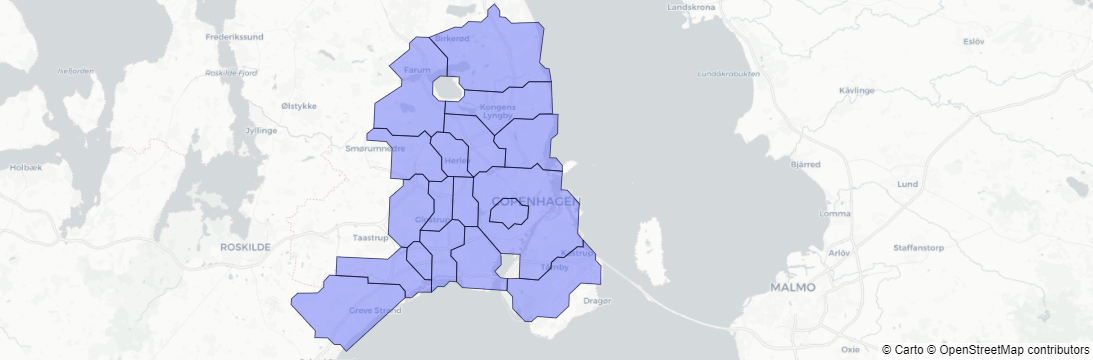

In [26]:
import geopandas as gpd
import plotly.express as px

# Assuming 'filtered_gdf' is already loaded and prepared as a GeoDataFrame
# You can use this directly to plot the borders without additional file loading or data preparation.

# Plot the map using Plotly - focusing only on the borders
fig = px.choropleth_mapbox(filtered_gdf,
                           geojson=filtered_gdf.geometry,
                           locations=filtered_gdf.index,
                           color_continuous_scale="Greys",  # Using a simple color scale for visualization
                           mapbox_style="carto-positron",
                           zoom=9, 
                           center={"lat": 55.6761, "lon": 12.5683},  # Center on Copenhagen, adjust as needed
                           opacity=0.5
                          )

fig.update_traces(marker_line_width=1, marker_line_color='black')  # Highlighting borders

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, showlegend=False)

fig.show()


In [28]:
import geopandas as gpd

# Step 1: Merge all geometries into one
merged_geometry = filtered_gdf['geometry'].unary_union

# Step 2: Create a new DataFrame with this single merged geometry
# Assuming you want to name this new municipality "Merged Municipality" and assign other necessary attributes
new_row = gpd.GeoDataFrame([{
    'Kommune': 'Merged Municipality',
    'shapeiso': None,
    'shapeid': None,
    'shapegroup': 'DNK',
    'shapetype': 'ADM2',
    'shape1': 'All Regions Combined',
    'shape0': 'denmark',
    'geometry': merged_geometry
}], crs=filtered_gdf.crs)  # Make sure to match the CRS of the original data

# Append this new row to the original GeoDataFrame
# filtered_gdf = filtered_gdf.append(new_row, ignore_index=True)


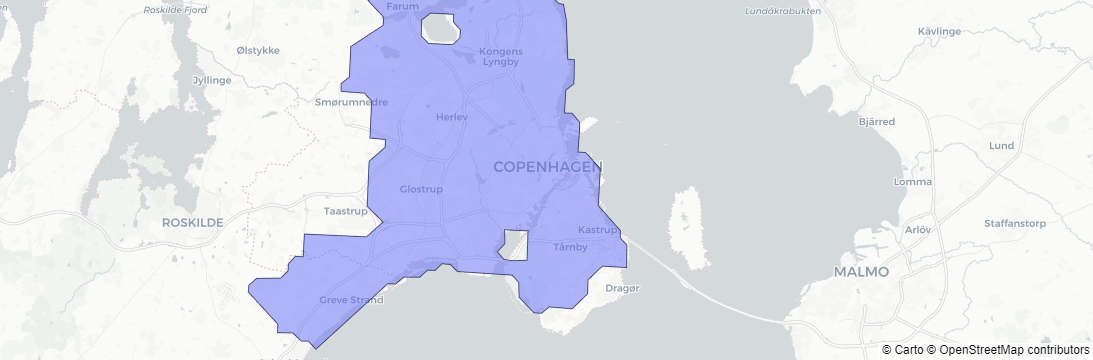

In [31]:

import geopandas as gpd
import plotly.express as px

# Assuming 'filtered_gdf' is already loaded and prepared as a GeoDataFrame
# You can use this directly to plot the borders without additional file loading or data preparation.

# Plot the map using Plotly - focusing only on the borders
fig = px.choropleth_mapbox(new_row,
                           geojson=new_row.geometry,
                           locations=new_row.index,
                           color_continuous_scale="Greys",  # Using a simple color scale for visualization
                           mapbox_style="carto-positron",
                           zoom=9, 
                           center={"lat": 55.6761, "lon": 12.5683},  # Center on Copenhagen, adjust as needed
                           opacity=0.5
                          )

fig.update_traces(marker_line_width=1, marker_line_color='black')  # Highlighting borders

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, showlegend=False)

fig.show()


In [32]:
new_row

,Kommune,shapeiso,shapeid,shapegroup,shapetype,shape1,shape0,geometry
0,Merged Municipality,None,None,DNK,ADM2,All Regions Combined,denmark,"POLYGON ((12.19925 55.56430, 12.15876 55.58919..."


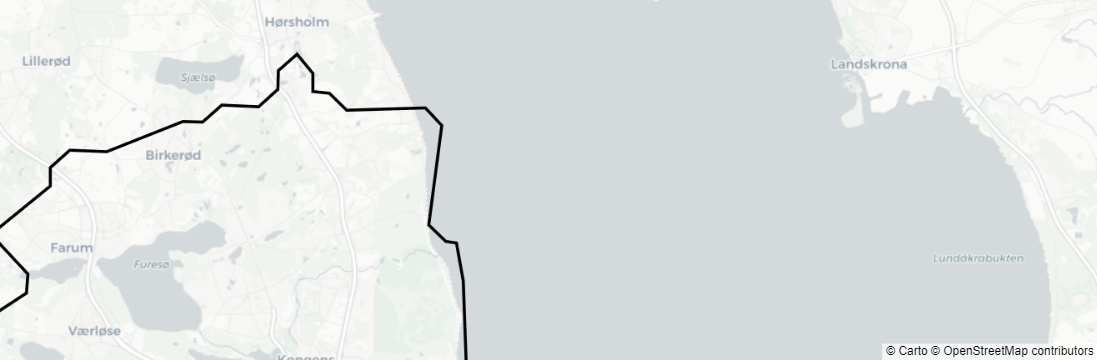

In [33]:
import geopandas as gpd
import plotly.express as px

# Extract the exterior coordinates of the merged geometry
coords_list = list(new_row.iloc[0]['geometry'].exterior.coords)

# Create a dataframe for Plotly from these coordinates
import pandas as pd

# Create a DataFrame for plotting
coord_df = pd.DataFrame(coords_list, columns=['longitude', 'latitude'])

# Plot the map using Plotly - focusing only on the borders as a line
fig = px.line_mapbox(coord_df,
                     lon='longitude',
                     lat='latitude',
                     mapbox_style="carto-positron",
                     zoom=9, 
                     center={"lat": 55.6761, "lon": 12.5683})  # Center on the rough center of the new municipality

fig.update_traces(line=dict(width=3, color='black'))  # Highlighting borders

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, showlegend=False)

fig.show()


In [40]:
coord_df
# Create an array of tuples (latitude, longitude)
coords_array = np.array(list(zip(coord_df['latitude'], coord_df['longitude'])))

In [41]:
coords_array

array([[55.56430001, 12.19925103],
       [55.58919064, 12.15875853],
       [55.59452229, 12.15954479],
       [55.59985322, 12.17015933],
       [55.60007533, 12.20318234],
       [55.60562758, 12.21340375],
       [55.610957  , 12.21379688],
       [55.61695173, 12.22323203],
       [55.6166142 , 12.23412302],
       [55.63424765, 12.23575938],
       [55.63204551, 12.32112167],
       [55.64358389, 12.34392327],
       [55.65556246, 12.32190793],
       [55.69058982, 12.32465985],
       [55.70144637, 12.34667519],
       [55.70742726, 12.34706832],
       [55.70853473, 12.32583924],
       [55.73709666, 12.32819803],
       [55.74329339, 12.31836975],
       [55.74462113, 12.286133  ],
       [55.75059541, 12.286133  ],
       [55.75590511, 12.2975338 ],
       [55.77934766, 12.29949946],
       [55.79570486, 12.34392327],
       [55.80189228, 12.34470953],
       [55.81470595, 12.32348046],
       [55.83035443, 12.35762711],
       [55.83632493, 12.35762711],
       [55.8419434 ,